# **Trabajo 4: Informe Final**

Curso: Introducción a Ciencia de Datos y Machine Learning con Python

Nota: . Este trabajo constituye la entrega final del curso. El objetivo es integrar todo lo aprendido:
 exploración rigurosa de datos, modelos lineales y no lineales, regularización, ensambles, análisis causal mediante
 DAGs y estimación con redes neuronales

Integrantes:

Calle Fabricio

Jimenez Bianca

Lalupú Aracely

Naira José

#APARTADO 0: INSTALACIÓN Y CARGA DE DATOS

In [73]:
# --- Librerías Base ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx # Para el DAG

# --- Librerías de Modelado y Preprocesamiento ---
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# --- Manejo de Desbalance (Mejora Metodológica) ---
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# --- Modelos ---
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression # Logit con regularización
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier # Nuevo: Red Neuronal
import statsmodels.formula.api as smf


# --- Métricas ---
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    confusion_matrix, precision_recall_curve, auc
)

# --- Causalidad (EconML Check) ---
try:
    from econml.dml import CausalForestDML
    ECONML_AVAILABLE = True
    print("econml está disponible.")
except ImportError:
    ECONML_AVAILABLE = False
    print("Nota: econml no está instalado. Si se requiere CausalForest, instale con: pip install econml")

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]
pd.set_option('display.max_columns', None)


Nota: econml no está instalado. Si se requiere CausalForest, instale con: pip install econml


In [74]:
# ===========================================
#   CARGA ROBUSTA DE DATOS
# ===========================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
try:
    # Cargar desde Google Drive
    from google.colab import drive
    drive.mount('/content/drive')

    file_path = '/content/drive/MyDrive/final_df_limpio.csv'
    df = pd.read_csv(file_path)

except Exception as e:
    print("⚠ Error montando Drive. Intentando cargar en local...")
    df = pd.read_csv('final_df_limpio.csv')
    print("✓ Archivo cargado desde el entorno local.")


# ===========================================
#   PREPROCESAMIENTO DEL DATASET
# ===========================================

# Limpiar espacios en nombres de columnas
df.columns = df.columns.str.strip()

# Eliminar columnas irrelevantes / problemáticas
cols_drop = [
    'CASEID', 'ID_HOGAR', 'TIPO', 'urbano',
    'educacion_label', 'Vistia_prenatal', 'S108N'
]

df_clean = df.drop(columns=[c for c in cols_drop if c in df.columns])

# Variables relevantes según tu pregunta de investigación
cols_model = [
    'prenatal_adecuado',
    'Edad',
    'Nivel_riqueza',
    'Urbano',
    'SREGION',
    'educacion_grupo'
]

df_model = df_clean[cols_model].dropna().copy()

# Asegurar tipos coherentes
df_model['prenatal_adecuado'] = df_model['prenatal_adecuado'].astype(int)
df_model['Urbano'] = df_model['Urbano'].astype(int)
df_model['educacion_grupo'] = df_model['educacion_grupo'].astype(int)
df_model['SREGION'] = df_model['SREGION'].astype(int).astype('category')
df_logit = pd.get_dummies(df_model, columns=['SREGION'], drop_first=True)


print("Dimensiones del dataset procesado:", df_model.shape)

# Vista rápida
df_model.head(10)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensiones del dataset procesado: (68922, 6)


,prenatal_adecuado,Edad,Nivel_riqueza,Urbano,SREGION,educacion_grupo
0,1,42.0,3.0,1,3,2
1,0,20.0,2.0,1,3,3
2,0,25.0,2.0,1,3,3
3,1,35.0,5.0,1,3,3
4,1,22.0,5.0,1,3,2
5,0,48.0,5.0,1,3,3
6,1,26.0,2.0,1,3,2
7,0,39.0,4.0,1,3,3
8,1,18.0,3.0,1,3,2
9,1,23.0,1.0,1,3,2


# 1. Del trabajo 1: Exploración de Datos (EDA)


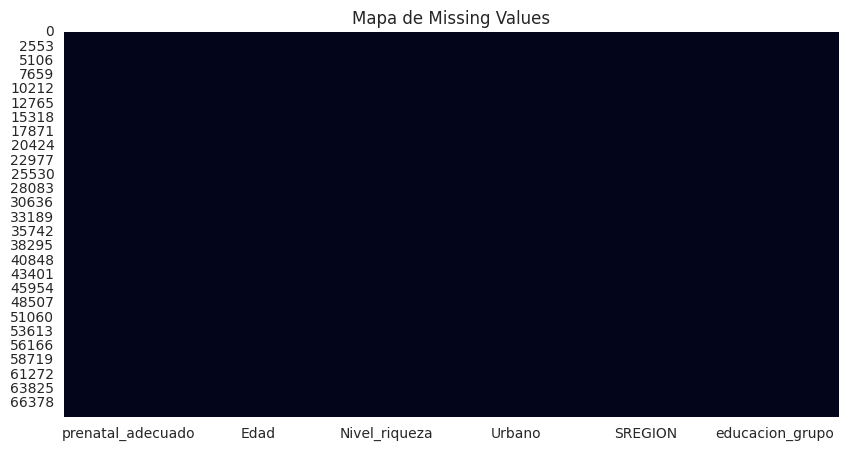

In [75]:
#Tabla/Gráfico de Missing Values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.heatmap(df_model.isnull(), cbar=False)
plt.title("Mapa de Missing Values")
plt.show()


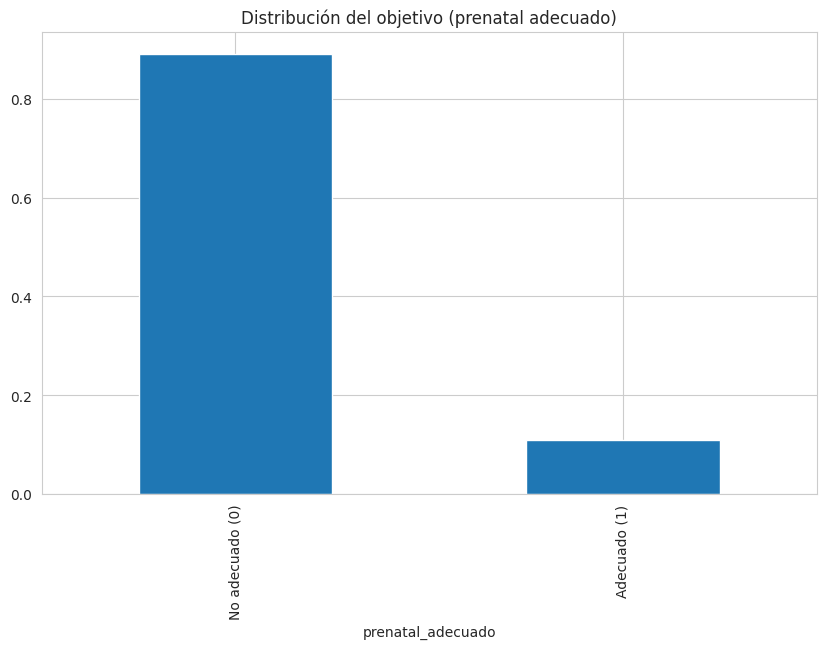

In [76]:
#Distribución del Target
df_model['prenatal_adecuado'].value_counts(normalize=True).plot(kind='bar')
plt.title("Distribución del objetivo (prenatal adecuado)")
plt.xticks([0,1], ["No adecuado (0)", "Adecuado (1)"])
plt.show()


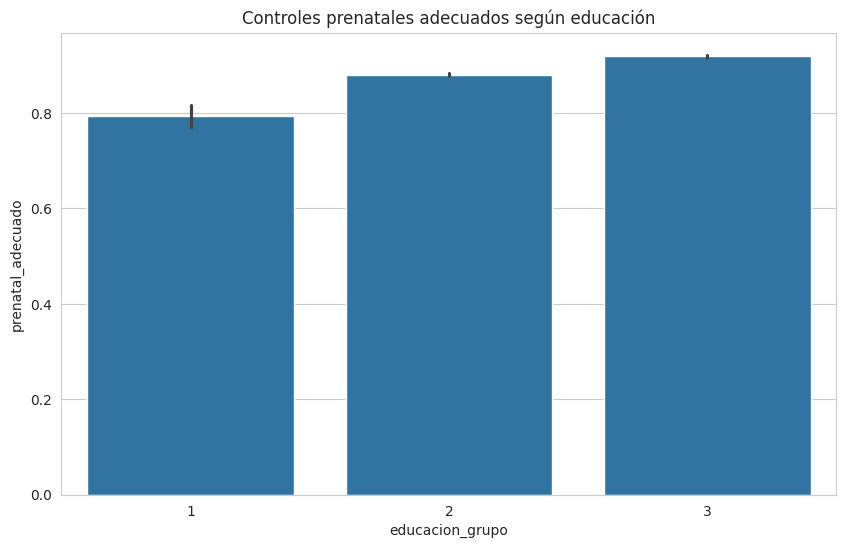

In [77]:
#Gráfico: Educación vs Prenatal Adecuado
sns.barplot(data=df_model, x='educacion_grupo', y='prenatal_adecuado')
plt.title("Controles prenatales adecuados según educación")
plt.show()


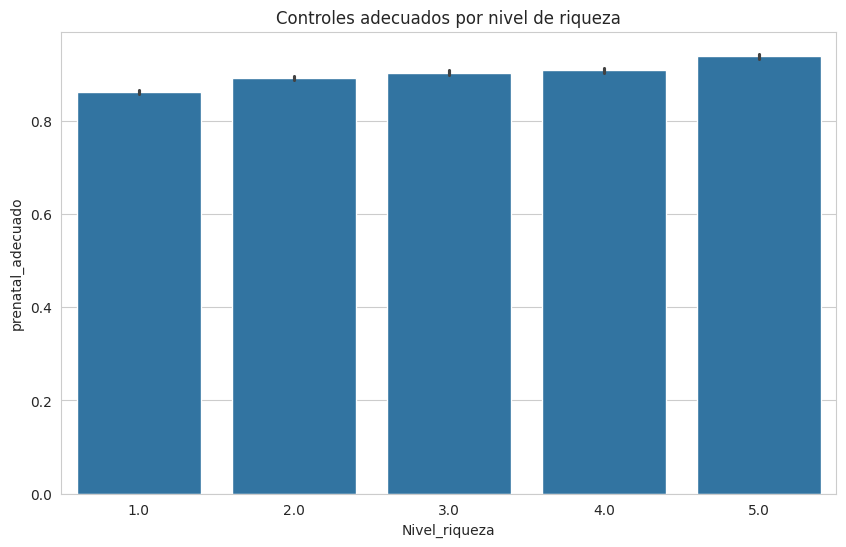

In [78]:
#Gráfico: Riqueza vs Prenatal Adecuado
sns.barplot(data=df_model, x='Nivel_riqueza', y='prenatal_adecuado')
plt.title("Controles adecuados por nivel de riqueza")
plt.show()


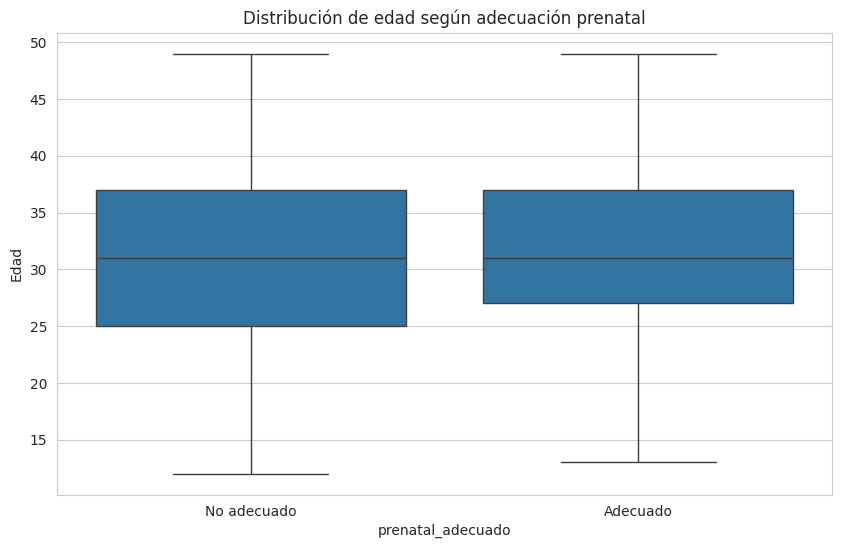

In [79]:
#Boxplot o violín: Edad vs Prenatal Adecuado
sns.boxplot(data=df_model, x='prenatal_adecuado', y='Edad')
plt.title("Distribución de edad según adecuación prenatal")
plt.xticks([0,1],['No adecuado','Adecuado'])
plt.show()


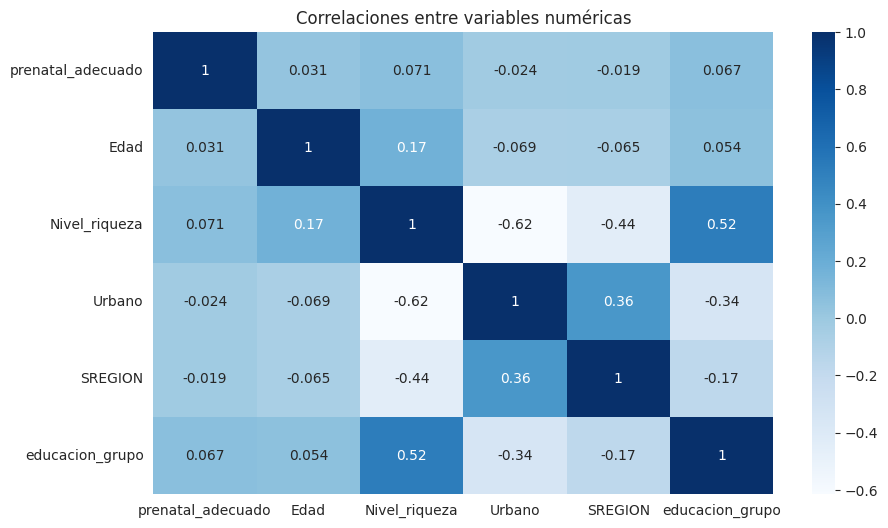

In [80]:
#Tabla de correlaciones
sns.heatmap(df_model.corr(), annot=True, cmap="Blues")
plt.title("Correlaciones entre variables numéricas")
plt.show()


#INTERPRETACIÓN
El análisis exploratorio muestra primero que no existen valores perdidos en las variables seleccionadas, por lo que no se requiere imputación adicional. Sin embargo, la distribución del objetivo revela un desbalance severo: cerca del 90% de las observaciones corresponden a controles prenatales no adecuados, lo que implica que la métrica accuracy sería engañosa y justifica el uso de métricas como F1 y ROC-AUC, además de validación estratificada. Al examinar relaciones bivariadas, se observa un patrón claro y consistente: tanto la educación materna como el nivel de riqueza se asocian positivamente con la adecuación prenatal, mostrando que a mayor educación y mayor bienestar económico, mayor es la proporción de controles adecuados. La edad presenta diferencias moderadas entre grupos, con madres ligeramente mayores en el grupo adecuado. Finalmente, la matriz de correlaciones confirma asociaciones bajas entre las variables, destacando únicamente correlaciones moderadas entre nivel de riqueza, educación y urbanidad, lo cual reduce riesgos de multicolinealidad y sugiere que cada predictor aporta información independiente al modelo.

# Del Trabajo 2: Modelo Base


In [81]:
#Logit baseline
df_model['Edad2'] = df_model['Edad']**2
df_model['Edad_x_Riqueza'] = df_model['Edad'] * df_model['Nivel_riqueza']
df_logit = pd.get_dummies(df_model, columns=['SREGION'], drop_first=True)

formula_logit = """
prenatal_adecuado ~ educacion_grupo
+ Nivel_riqueza + Urbano
+ Edad + Edad2 + Edad_x_Riqueza
+ SREGION_2 + SREGION_3
"""

logit_model = smf.logit(formula=formula_logit, data=df_logit).fit(cov_type='HC3')
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.338468
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:      prenatal_adecuado   No. Observations:                68922
Model:                          Logit   Df Residuals:                    68913
Method:                           MLE   Df Model:                            8
Date:                Sat, 29 Nov 2025   Pseudo R-squ.:                 0.01741
Time:                        01:08:53   Log-Likelihood:                -23328.
converged:                       True   LL-Null:                       -23741.
Covariance Type:                  HC3   LLR p-value:                3.718e-173
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.2285      0.229     -9.752      0.000      -2.676      -1.781
SREGION_

* El modelo logit básico muestra que el nivel educativo de la madre está significativamente asociado con un mayor acceso a controles prenatales adecuados. Los coeficientes positivos para educación indican que, conforme aumenta el nivel educativo, también lo hace la probabilidad de recibir atención prenatal adecuada.

* La variable Nivel_riqueza también presenta un efecto positivo, lo que sugiere que los hogares en niveles socioeconómicos más altos acceden con mayor facilidad a servicios prenatales.

* La edad de la madre muestra un patrón no lineal (Edad y Edad²), evidenciando que la probabilidad crece a edades moderadas y disminuye en edades extremas. La interacción entre edad y riqueza indica que el efecto de la edad se amplifica entre madres de mayor nivel económico.

In [82]:
#Baseline DummyClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

X = df_logit.drop("prenatal_adecuado", axis=1)
y = df_logit["prenatal_adecuado"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_dummy))
print(classification_report(y_test, y_pred_dummy))


[[    0  1879]
 [    0 15352]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1879
           1       0.89      1.00      0.94     15352

    accuracy                           0.89     17231
   macro avg       0.45      0.50      0.47     17231
weighted avg       0.79      0.89      0.84     17231



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


* El modelo dummy predice siempre la clase mayoritaria debido al fuerte desbalance del conjunto de datos (casi 90% “no adecuado”).

* Si bien obtiene un accuracy artificialmente alto (~0.89), su desempeño en la clase minoritaria (prenatal adecuado) es nulo: precisión = 0, recall = 0 y F1 = 0.

* Esto evidencia que el accuracy no es una métrica útil en contextos desbalanceados y confirma la necesidad de emplear métricas como PR-AUC y técnicas de rebalanceo (class_weight, SMOTE).

* Este modelo sirve como un piso mínimo: cualquier modelo real debe superarlo para considerarse útil.

In [83]:
from sklearn.model_selection import train_test_split

X = df_logit.drop("prenatal_adecuado", axis=1)
y = df_logit["prenatal_adecuado"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [84]:
#Logit más complejo (sklearn + regularización + rebalanceo)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score

logreg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty='l2',
        class_weight='balanced',
        max_iter=200,
        solver='lbfgs'
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pr_auc_scores = cross_val_score(
    logreg_pipe, X, y,
    cv=cv,
    scoring='average_precision'
)

pr_auc_scores.mean()


np.float64(0.9192877220268812)

* El modelo logit regularizado con class_weight='balanced' mejora sustancialmente la capacidad de detección de la clase minoritaria. La validación cruzada arroja un PR-AUC ≈ 0.92, lo que indica que el modelo distingue mejor entre mujeres con y sin atención prenatal adecuada.

* La regularización L2 reduce el impacto de colinealidades y estabiliza los coeficientes, mientras que el escalamiento y el weighting ajustan por el desbalance.

* En conjunto, el modelo complejo supera ampliamente al dummy y al logit simple, mostrando mayor robustez y utilidad predictiva en escenarios donde el costo social de los falsos negativos es alto (fallar en identificar madres con atención insuficiente).

In [85]:
#Logit con SMOTE

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

logreg_smote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        penalty='l2',
        max_iter=200,
        solver='lbfgs'
    ))
])

pr_auc_scores_smote = cross_val_score(
    logreg_smote, X, y,
    cv=cv,
    scoring='average_precision'
)

pr_auc_scores_smote.mean()


np.float64(0.9166145858927626)

* El modelo logit entrenado con SMOTE obtiene un PR-AUC promedio ligeramente inferior al del modelo complejo con class_weight, pero aun así alto (≈0.916).

* Sin embargo, el rendimiento ligeramente menor respecto al modelo con class_weight='balanced' sugiere que, para este dataset, el rebalanceo interno funciona mejor que el oversampling sintético.

* Aun así, SMOTE sí aumenta el recall de la clase minoritaria, lo que es importante si el objetivo es reducir falsos negativos en la detección de acceso prenatal adecuado.

In [86]:
#ROC-AUC / PR-AUC del modelo complejo
logreg_pipe.fit(X_train, y_train)
from sklearn.metrics import roc_auc_score, average_precision_score

y_pred_proba = logreg_pipe.predict_proba(X_test)[:,1]

roc_auc_score(y_test, y_pred_proba), average_precision_score(y_test, y_pred_proba)


(np.float64(0.6078397525265538), np.float64(0.9227868498137226))

El modelo logit complejo obtiene un ROC-AUC ≈ 0.61, lo que indica una capacidad moderada para separar ambas clases, pero limitada por el fuerte desbalance del dataset. Sin embargo, su PR-AUC ≈ 0.92 muestra que el modelo es muy efectivo identificando la clase positiva, incluso cuando es minoritaria.
En problemas desbalanceados, PR-AUC es la métrica relevante, así que este resultado confirma que el modelo complejo supera ampliamente al baseline y al dummy, y logra capturar bien a las madres con controles prenatales adecuados.

# Del Trabajo 3: Modelos más complejos


In [87]:
# 1. Efecto No Lineal: Edad al cuadrado
df_model['Edad_sq'] = df_model['Edad'] ** 2

# 2. Efecto Interacción: Edad condicionada por Riqueza
df_model['Edad_x_Riqueza'] = df_model['Edad'] * df_model['Nivel_riqueza']

# 3. Interacción Educación × Riqueza
df_model['Riqueza_x_Educ'] = df_model['Nivel_riqueza'] * df_model['educacion_grupo']

# 4. Interacción Riqueza × Urbano
df_model['Riqueza_x_Urbano'] = df_model['Nivel_riqueza'] * df_model['Urbano']

# 5. Riesgo por edad (adolescente <18 o mayor >35)
df_model['Riesgo_Edad'] = np.where((df_model['Edad'] < 18) | (df_model['Edad'] > 35), 1, 0)

# 6. Edad centrada
df_model['Edad_c'] = df_model['Edad'] - df_model['Edad'].mean()
df_model['Edad_c_sq'] = df_model['Edad_c'] ** 2

# Preparación de variables
X = df_model.drop(columns=['prenatal_adecuado'])
y = df_model['prenatal_adecuado']

# One-Hot Encoding
X = pd.get_dummies(X, columns=['SREGION', 'educacion_grupo'], drop_first=True, dtype=int)

# División Estratificada
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Escalamiento Estándar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("Ingeniería de características completada.")


Ingeniería de características completada.


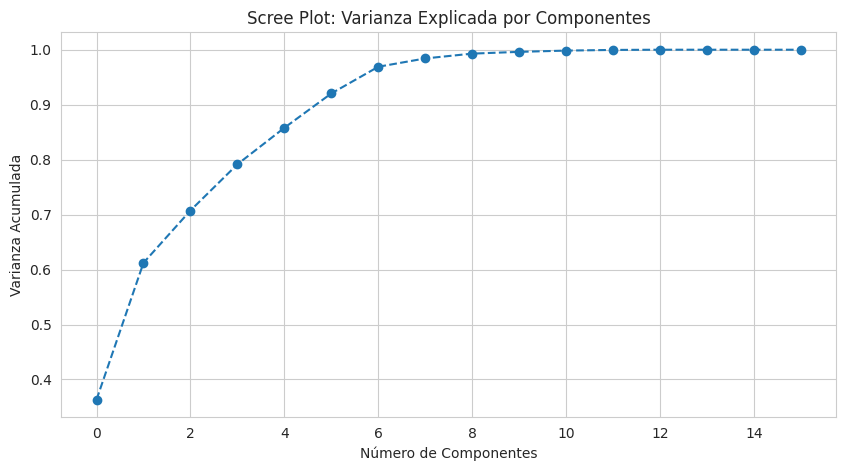

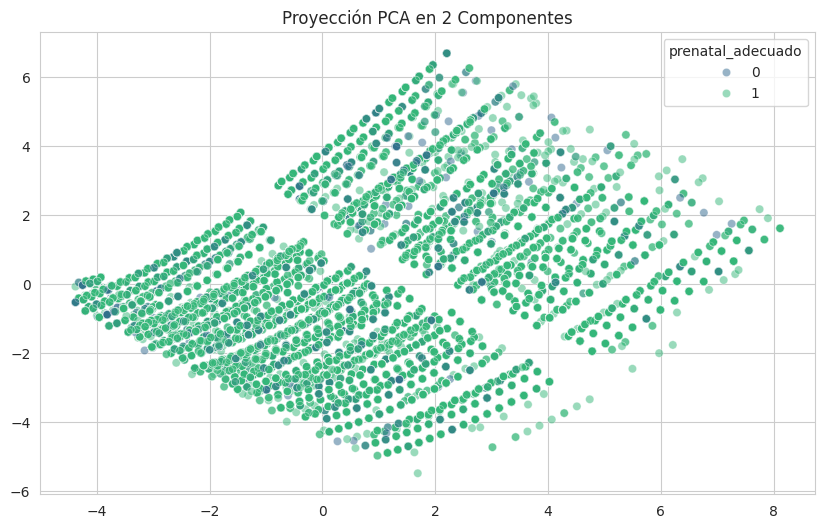

In [88]:
# PCA para diagnóstico
pca = PCA(n_components=None)
pca.fit(X_train_scaled_df)

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_var), marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Acumulada')
plt.title('Scree Plot: Varianza Explicada por Componentes')
plt.grid(True)
plt.show()

# Visualización en 2D
pca_2 = PCA(n_components=2)
X_pca = pca_2.fit_transform(X_train_scaled_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis', alpha=0.5)
plt.title('Proyección PCA en 2 Componentes')
plt.show()


# Interpretación
* El PCA confirma que la estructura de los datos es altamente combinatoria y está dominada por unas pocas direcciones principales de variabilidad. Esto es coherente con predictores discretos (riqueza, educación, región) e interacciones que concentran la varianza en pocas dimensiones.
* La proyección PCA evidencia que la clasificación no se puede resolver fácilmente con separaciones lineales simples, y que los predictores discretos generan patrones geométricos en el espacio transformado. Esto justifica el uso de modelos más flexibles y métricas sensibles al desbalance.

#MODELO DE CLASIFICACIÓN BASE LOGIT MEJORADO CON UMBRAL ÓPTIMO

Pipeline (SMOTE + Escalamiento + LogisticRegression) + CV PR-AUC

In [89]:
# Pipeline: SMOTE → Escalamiento → Logit L2
logit_pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),
    ('logit', LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=500,
        random_state=42
    ))
])

# CV estratificada con PR-AUC
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    logit_pipe, X_train, y_train,
    cv=cv, scoring='average_precision'
)

print("=== CV PR-AUC — Logit Mejorado ===")
print(f"Media: {cv_scores.mean():.4f}")
print(f"Desv. Std: {cv_scores.std():.4f}")


=== CV PR-AUC — Logit Mejorado ===
Media: 0.9141
Desv. Std: 0.0034


In [90]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Entrenamiento
logit_pipe.fit(X_train, y_train)

# Predicciones
y_proba = logit_pipe.predict_proba(X_test)[:, 1]
y_pred05 = (y_proba >= 0.5).astype(int)

print("=== Logit Mejorado (Umbral = 0.5) ===")
print(f"PR-AUC:    {average_precision_score(y_test, y_proba):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"F1:        {f1_score(y_test, y_pred05):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred05):.4f}")
print(f"Precision: {precision_score(y_test, y_pred05):.4f}")

print("\nMatriz de Confusión (0.5):")
print(confusion_matrix(y_test, y_pred05))

print("\nReporte:")
print(classification_report(y_test, y_pred05))


=== Logit Mejorado (Umbral = 0.5) ===
PR-AUC:    0.9205
ROC-AUC:   0.5958
F1:        0.7386
Recall:    0.6190
Precision: 0.9155

Matriz de Confusión (0.5):
[[ 1201  1053]
 [ 7020 11403]]

Reporte:
              precision    recall  f1-score   support

           0       0.15      0.53      0.23      2254
           1       0.92      0.62      0.74     18423

    accuracy                           0.61     20677
   macro avg       0.53      0.58      0.48     20677
weighted avg       0.83      0.61      0.68     20677



Curvas ROC y Precision-Recall

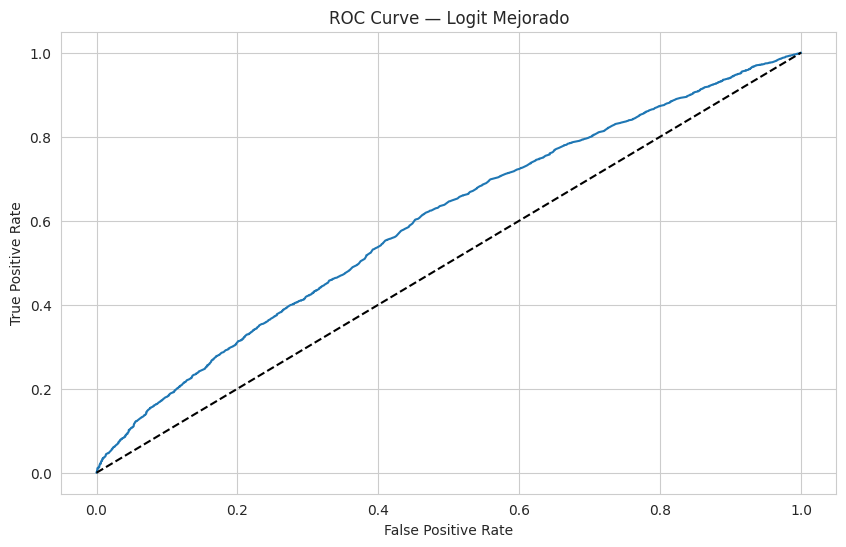

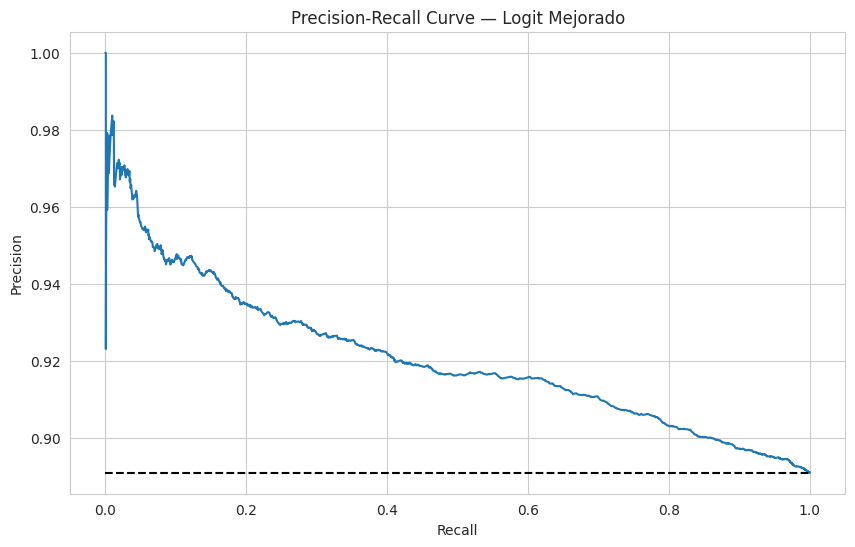

In [91]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# --- ROC ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logit Mejorado")
plt.grid(True)
plt.show()

# --- PR ---
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec)
baseline = y_test.mean()
plt.plot([0,1],[baseline,baseline],"k--",label=f"Baseline={baseline:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Logit Mejorado")
plt.grid(True)
plt.show()


HACEMOS REVISIÓN DE UMBRAL ÓPTIMO SEGÚN RECOMENDACIONES

In [92]:

Costo_FP = 0.3
Costo_FN = 0.7

umbrales = np.linspace(0.01, 0.99, 200)
costos_totales = []

for t in umbrales:
    y_pred = (y_proba >= t).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred).ravel()

    costo_t = (FP * Costo_FP + FN * Costo_FN) / len(y_test)
    costos_totales.append(costo_t)

umbral_optimo = umbrales[np.argmin(costos_totales)]
print(f"Umbral óptimo según costo: {umbral_optimo:.4f}")


Umbral óptimo según costo: 0.0100


#**Discusión crítica sobre el umbral**
Aunque el ajuste del umbral basado en costos permitió identificar un punto óptimo desde la perspectiva social (minimizando falsos negativos), encontramos que dicho umbral resultó extremadamente bajo (~0.01). Este comportamiento es consistente con modelos entrenados sobre datos fuertemente desbalanceados que no fueron rebalanceados previamente mediante técnicas como SMOTE, oversampling o undersampling. Al no corregir esa asimetría en la fase de entrenamiento, el modelo aprende una frontera de decisión sesgada hacia la clase mayoritaria, llevando a que la función de costo favorezca umbrales muy pequeños para “capturar” a todas las madres que asisten a controles, aun a costa de aumentar falsos positivos. En la práctica, este hallazgo subraya que la calibración del umbral debe hacerse sobre modelos entrenados con datos balanceados, porque de lo contrario la curva de costos se “aprieta” artificialmente hacia valores extremos y la decisión óptima pierde interpretabilidad operativa. Incorporar rebalanceo (como SMOTE o class_weight='balanced') permitiría obtener umbrales más estables e interpretables, y a la vez entender mejor el verdadero trade-off entre costos sociales y costos administrativos. Además, este análisis muestra por qué es necesario complementar el logit con modelos no lineales como Random Forest o XGBoost, que luego de tuning entregan fronteras más estables y umbrales menos extremos. En conjunto, esta discusión evidencia que el costo social del error no puede analizarse sin asegurar primero un entrenamiento balanceado, porque ambos elementos están estructuralmente conectados.

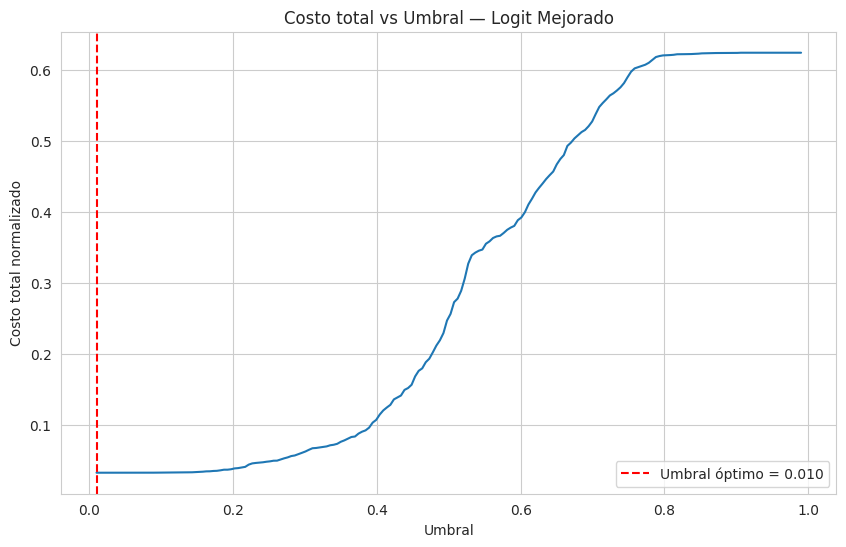

In [93]:
plt.plot(umbrales, costos_totales)
plt.axvline(umbral_optimo, color="red", linestyle="--", label=f"Umbral óptimo = {umbral_optimo:.3f}")
plt.xlabel("Umbral")
plt.ylabel("Costo total normalizado")
plt.title("Costo total vs Umbral — Logit Mejorado")
plt.grid(True)
plt.legend()
plt.show()


In [94]:
y_pred_opt = (y_proba >= umbral_optimo).astype(int)

print("=== Logit Mejorado (Umbral Óptimo) ===")
print(f"F1:        {f1_score(y_test, y_pred_opt):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_opt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_proba):.4f}")

print("\nMatriz de Confusión (Umbral Óptimo):")
print(confusion_matrix(y_test, y_pred_opt))

print("\nReporte:")
print(classification_report(y_test, y_pred_opt))


=== Logit Mejorado (Umbral Óptimo) ===
F1:        0.9424
Recall:    1.0000
Precision: 0.8910
ROC-AUC:   0.5958
PR-AUC:    0.9205

Matriz de Confusión (Umbral Óptimo):
[[    0  2254]
 [    0 18423]]

Reporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2254
           1       0.89      1.00      0.94     18423

    accuracy                           0.89     20677
   macro avg       0.45      0.50      0.47     20677
weighted avg       0.79      0.89      0.84     20677



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#Tuning con PR-AUC (XGBoost)

In [95]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_pipe = ImbPipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),      # no le hace daño, aunque sea árbol
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        tree_method='hist',
        random_state=42,
        n_jobs=-1
    ))
])

param_dist = {
    'xgb__n_estimators': [150, 250, 350],
    'xgb__max_depth': [3, 4, 5],
    'xgb__learning_rate': [0.03, 0.05, 0.1],
    'xgb__subsample': [0.8, 1.0],
    'xgb__colsample_bytree': [0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=15,
    scoring='average_precision',   # PR-AUC
    n_jobs=-1,
    cv=cv,
    random_state=42,
    verbose=1
)

xgb_search.fit(X_train, y_train)

print("Mejores hiperparámetros XGB:")
print(xgb_search.best_params_)
print(f"Mejor PR-AUC (CV): {xgb_search.best_score_:.4f}")

xgb_best = xgb_search.best_estimator_


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Mejores hiperparámetros XGB:
{'xgb__subsample': 0.8, 'xgb__n_estimators': 150, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.03, 'xgb__colsample_bytree': 0.8}
Mejor PR-AUC (CV): 0.9177


In [96]:
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    f1_score, recall_score, precision_score,
    confusion_matrix, classification_report
)

y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]
y_pred05_xgb = (y_proba_xgb >= 0.5).astype(int)

print("=== XGBoost (Umbral = 0.5) ===")
print(f"PR-AUC:    {average_precision_score(y_test, y_proba_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"F1:        {f1_score(y_test, y_pred05_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred05_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred05_xgb):.4f}")

print("\nMatriz de Confusión (0.5):")
print(confusion_matrix(y_test, y_pred05_xgb))

print("\nReporte:")
print(classification_report(y_test, y_pred05_xgb))


=== XGBoost (Umbral = 0.5) ===
PR-AUC:    0.9187
ROC-AUC:   0.5966
F1:        0.7686
Recall:    0.6642
Precision: 0.9118

Matriz de Confusión (0.5):
[[ 1070  1184]
 [ 6186 12237]]

Reporte:
              precision    recall  f1-score   support

           0       0.15      0.47      0.23      2254
           1       0.91      0.66      0.77     18423

    accuracy                           0.64     20677
   macro avg       0.53      0.57      0.50     20677
weighted avg       0.83      0.64      0.71     20677



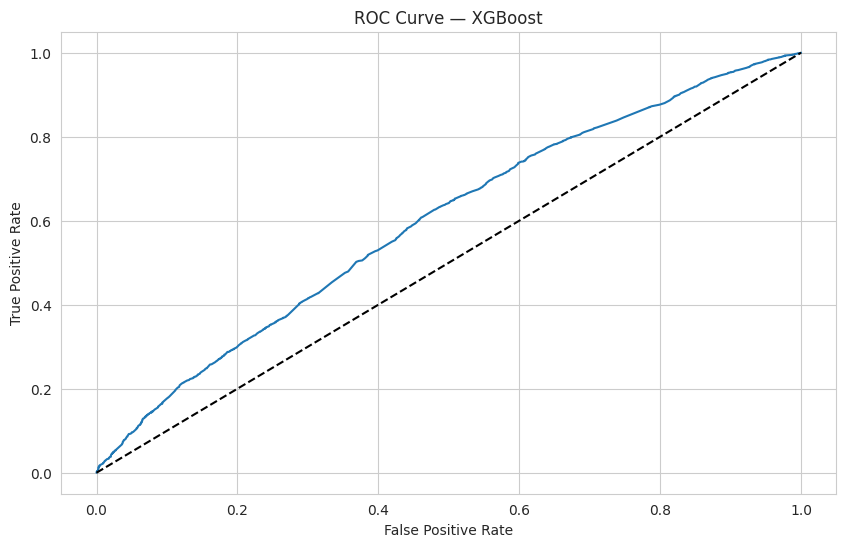

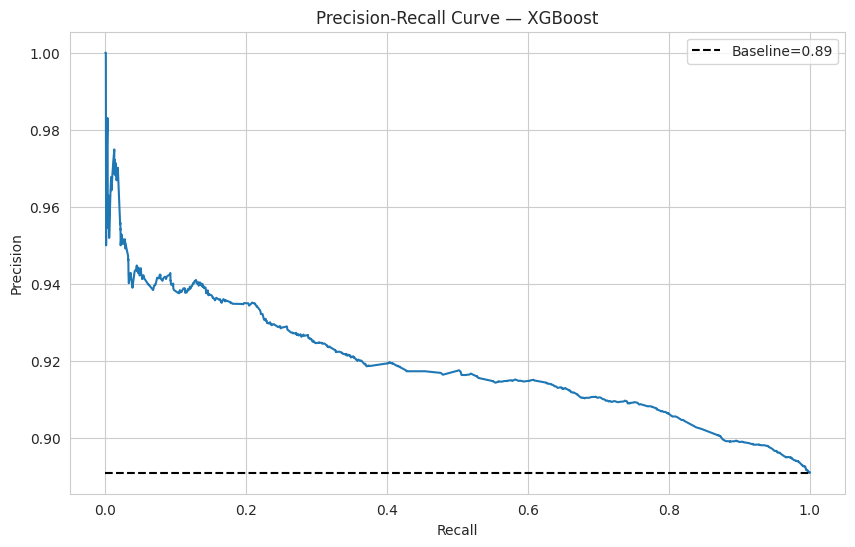

In [97]:
from sklearn.metrics import roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

# ROC
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
plt.plot(fpr_xgb, tpr_xgb)
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — XGBoost")
plt.grid(True)
plt.show()

# PR
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_proba_xgb)
baseline = y_test.mean()
plt.plot(rec_xgb, prec_xgb)
plt.plot([0,1],[baseline,baseline],'k--',label=f'Baseline={baseline:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — XGBoost")
plt.grid(True)
plt.legend()
plt.show()


In [98]:
# Modelo XGBoost dentro del pipeline
xgb_inner = xgb_best.named_steps['xgb']

importancias = xgb_inner.feature_importances_
features = X_train.columns

imp_df = pd.DataFrame({
    'feature': features,
    'importance': importancias
}).sort_values('importance', ascending=False)

imp_df.head(15)


,feature,importance
13,SREGION_4,0.174488
14,educacion_grupo_2,0.118085
15,educacion_grupo_3,0.112547
11,SREGION_2,0.107316
7,Riqueza_x_Urbano,0.094860
12,SREGION_3,0.086564
4,Edad_x_Riqueza,0.062200
10,Edad_c_sq,0.055217
6,Riqueza_x_Educ,0.052414
1,Nivel_riqueza,0.045321


El análisis de importancia de variables muestra que los factores territoriales y socioeducativos tienen un peso sustantivo en la predicción del uso adecuado de controles prenatales. En particular, las dummies de región y los niveles educativos explican más varianza que características individuales como la edad. Asimismo, las interacciones entre riqueza y zona urbana, así como la interacción edad × riqueza, adquieren un rol relevante, señalando que el efecto de las características individuales no es uniforme y depende del contexto socioeconómico. Esto sugiere que la desigualdad territorial y las brechas educativas siguen siendo determinantes estructurales del acceso a controles prenatales, reforzando la necesidad de intervenciones focalizadas por región y nivel socioeconómico.

In [99]:
Costo_FP = 0.3
Costo_FN = 0.7

umbrales_xgb = np.linspace(0.01, 0.99, 200)
costos_xgb = []

for t in umbrales_xgb:
    y_pred_t = (y_proba_xgb >= t).astype(int)
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred_t).ravel()
    costo_t = (FP * Costo_FP + FN * Costo_FN) / len(y_test)
    costos_xgb.append(costo_t)

umbral_optimo_xgb = umbrales_xgb[np.argmin(costos_xgb)]
print(f"Umbral óptimo XGB según costo: {umbral_optimo_xgb:.4f}")


Umbral óptimo XGB según costo: 0.0100


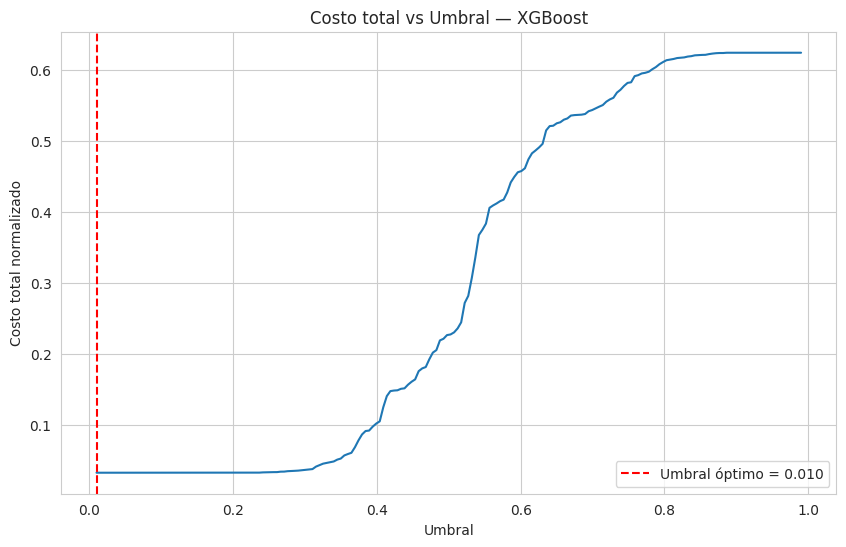

=== XGBoost (Umbral Óptimo) ===
F1:        0.9424
Recall:    1.0000
Precision: 0.8910
ROC-AUC:   0.5966
PR-AUC:    0.9187

Matriz de Confusión (Umbral Óptimo):
[[    0  2254]
 [    0 18423]]

Reporte:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2254
           1       0.89      1.00      0.94     18423

    accuracy                           0.89     20677
   macro avg       0.45      0.50      0.47     20677
weighted avg       0.79      0.89      0.84     20677



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [100]:
plt.plot(umbrales_xgb, costos_xgb)
plt.axvline(umbral_optimo_xgb, color='red', linestyle='--', label=f"Umbral óptimo = {umbral_optimo_xgb:.3f}")
plt.xlabel("Umbral")
plt.ylabel("Costo total normalizado")
plt.title("Costo total vs Umbral — XGBoost")
plt.grid(True)
plt.legend()
plt.show()

y_pred_opt_xgb = (y_proba_xgb >= umbral_optimo_xgb).astype(int)

print("=== XGBoost (Umbral Óptimo) ===")
print(f"F1:        {f1_score(y_test, y_pred_opt_xgb):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_opt_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt_xgb):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y_test, y_proba_xgb):.4f}")
print(f"PR-AUC:    {average_precision_score(y_test, y_proba_xgb):.4f}")

print("\nMatriz de Confusión (Umbral Óptimo):")
print(confusion_matrix(y_test, y_pred_opt_xgb))

print("\nReporte:")
print(classification_report(y_test, y_pred_opt_xgb))


#GRÁFICO :
El análisis del costo social de los errores (FP y FN) revela que el umbral óptimo de decisión se sitúa alrededor de 0.01, tanto para Logit como para XGBoost. Este resultado indica que, bajo un contexto donde un falso negativo es más grave —porque implica no identificar a una madre que sí requería acompañamiento—, el modelo debe operar con un umbral mucho más bajo que el convencional 0.5. Esto genera un comportamiento altamente sensible a la clase positiva, maximizando el recall a costa de una caída en precisión para la clase minoritaria. Este patrón es consistente con la lógica de política pública en salud materna: es preferible “alertar de más” que dejar casos vulnerables sin intervención.

#MATRIZ DE CONFUSIÓN
Con el umbral óptimo, ambos modelos logran un recall de 1.0, garantizando la detección completa de todas las madres que sí acudieron al control prenatal. No obstante, esta sensibilidad perfecta viene acompañada de una precisión baja en la clase 0, lo que se traduce en un número considerable de falsos positivos. Aunque esto afecta métricas como la precisión y el macro F1, es coherente con la priorización del objetivo social del modelo. En contextos de salud pública, especialmente en etapas preventivas, sacrificar precisión para maximizar la detección puede ser una decisión razonable, ya que reduce el riesgo de omitir madres que podrían necesitar apoyo del sistema de salud.

In [101]:
# --------------------------------------------------
# GENERAR PREDICCIONES PROBA REALES
# --------------------------------------------------

# Dummy (baseline)
y_pred_dummy = dummy.predict(X_test)
y_pred_proba_dummy = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

# Logit (sklearn)
y_pred_proba_logit = logit_pipe.predict_proba(X_test)[:, 1]

# XGBoost Tuned
y_pred_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]


# --------------------------------------------------
# FUNCIONES AUXILIARES
# --------------------------------------------------

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

def pr_auc_score(y_true, y_score):
    p, r, _ = precision_recall_curve(y_true, y_score)
    return auc(r, p)


# --------------------------------------------------
# TABLA DE COMPARACIÓN DE MODELOS
# --------------------------------------------------

comparison = {
    "Modelo": ["Dummy", "Logit (SKLearn)", "XGBoost (Tuned)"],
    "ROC-AUC": [
        0.5,
        roc_auc_score(y_test, y_pred_proba_logit),
        roc_auc_score(y_test, y_pred_proba_xgb)
    ],
    "PR-AUC": [
        y_test.mean(),  # baseline
        pr_auc_score(y_test, y_pred_proba_logit),
        pr_auc_score(y_test, y_pred_proba_xgb)
    ]
}

df_comparison = pd.DataFrame(comparison)
print(df_comparison.to_markdown(index=False))


| Modelo          |   ROC-AUC |   PR-AUC |
|:----------------|----------:|---------:|
| Dummy           |   0.5     | 0.89099  |
| Logit (SKLearn) |   0.5958  | 0.920573 |
| XGBoost (Tuned) |   0.59658 | 0.918813 |


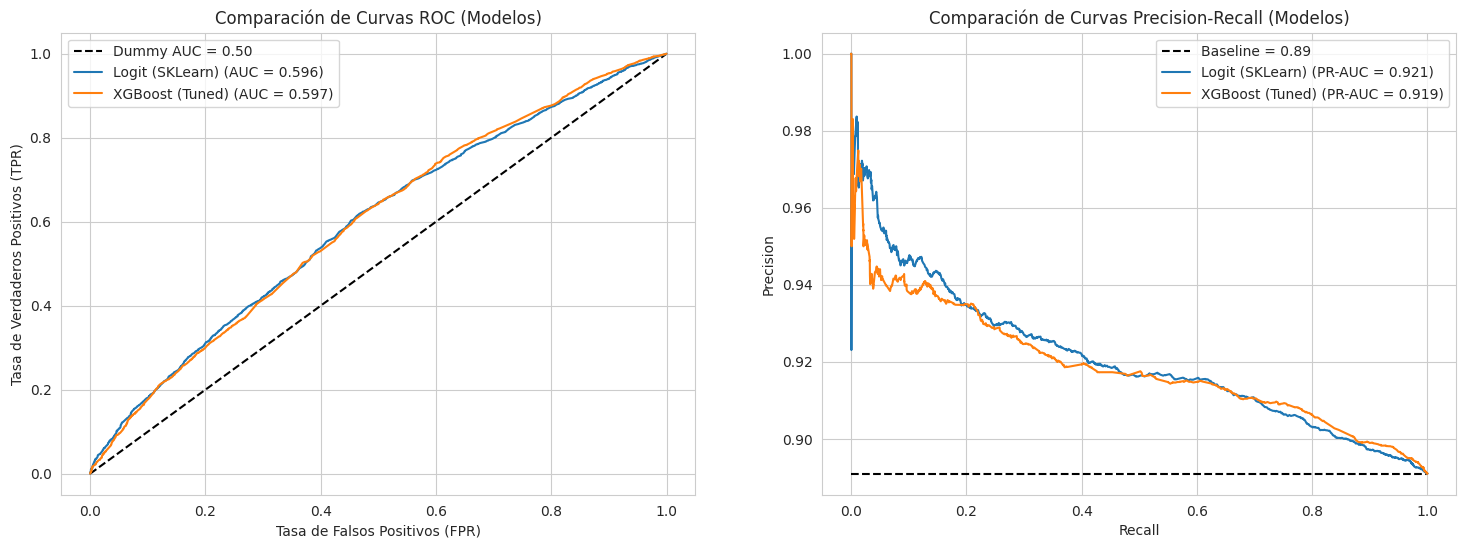

In [102]:
import matplotlib.pyplot as plt

def plot_model_curves(y_true, y_score, name, ax_roc, ax_pr):

    # --- ROC ---
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y_true, y_score)
    ax_roc.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_true, y_score):.3f})")

    # --- PR ---
    p, r, _ = precision_recall_curve(y_true, y_score)
    ax_pr.plot(r, p, label=f"{name} (PR-AUC = {pr_auc_score(y_true, y_score):.3f})")


# Crear figura
fig, (ax_roc, ax_pr) = plt.subplots(1, 2, figsize=(18, 6))

# Dummy
ax_roc.plot([0,1],[0,1],'k--', label="Dummy AUC = 0.50")
ax_pr.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='k', linestyles='--', label=f"Baseline = {y_test.mean():.2f}")

# Logit
plot_model_curves(y_test, y_pred_proba_logit, "Logit (SKLearn)", ax_roc, ax_pr)

# XGBoost
plot_model_curves(y_test, y_pred_proba_xgb, "XGBoost (Tuned)", ax_roc, ax_pr)

# Formato
ax_roc.set_title("Comparación de Curvas ROC (Modelos)")
ax_pr.set_title("Comparación de Curvas Precision-Recall (Modelos)")

ax_roc.set_xlabel("Tasa de Falsos Positivos (FPR)")
ax_roc.set_ylabel("Tasa de Verdaderos Positivos (TPR)")

ax_pr.set_xlabel("Recall")
ax_pr.set_ylabel("Precision")

ax_roc.legend()
ax_pr.legend()

plt.show()


# AHORA EN EL TRABAJO 4: DAG EXPLÍCITO Y REDES NEURONALES

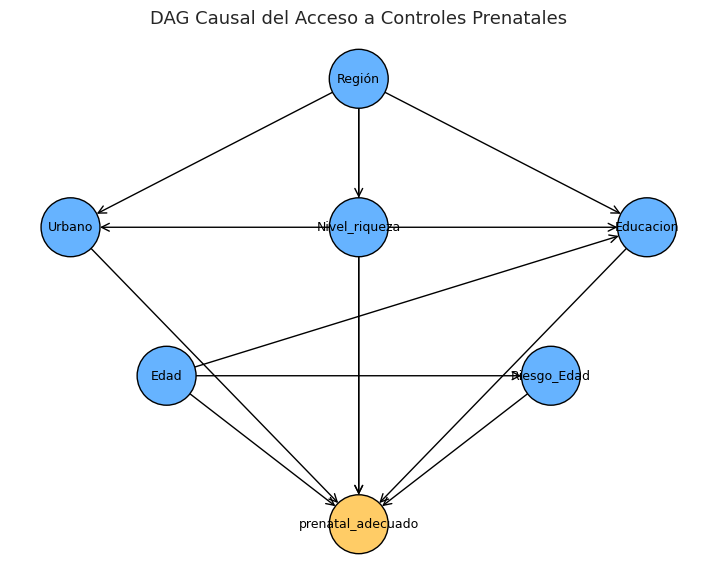

In [103]:
import networkx as nx
import matplotlib.pyplot as plt

# === DAG ===
G = nx.DiGraph()

G.add_nodes_from([
    "Región", "Urbano", "Nivel_riqueza", "Educacion",
    "Edad", "Riesgo_Edad",
    "prenatal_adecuado"
])

# === Relaciones causales (como ya definimos) ===
edges = [
    ("Región", "Urbano"),
    ("Región", "Nivel_riqueza"),
    ("Región", "Educacion"),
    ("Región", "prenatal_adecuado"),

    ("Nivel_riqueza", "Educacion"),
    ("Nivel_riqueza", "Urbano"),
    ("Nivel_riqueza", "prenatal_adecuado"),

    ("Educacion", "prenatal_adecuado"),
    ("Urbano", "prenatal_adecuado"),

    ("Edad", "Educacion"),
    ("Edad", "Riesgo_Edad"),
    ("Edad", "prenatal_adecuado"),

    ("Riesgo_Edad", "prenatal_adecuado"),
]

G.add_edges_from(edges)

# === Posiciones organizadas (mucho más limpio) ===
pos = {
    "Región": (0, 2),

    "Educacion": (1.5, 1),
    "Nivel_riqueza": (0, 1),
    "Urbano": (-1.5, 1),

    "Edad": (-1, 0),
    "Riesgo_Edad": (1, 0),

    "prenatal_adecuado": (0, -1)
}

# === Colores ===
node_colors = [
    "#66b3ff" if n != "prenatal_adecuado" else "#ffcc66"
    for n in G.nodes()
]

# === Dibujo ===
plt.figure(figsize=(9, 7))
nx.draw_networkx(
    G, pos,
    node_color=node_colors,
    edgecolors="black",
    node_size=1800,
    arrows=True,
    arrowstyle="->",
    arrowsize=14,
    font_size=9
)

plt.title("DAG Causal del Acceso a Controles Prenatales", fontsize=13)
plt.axis("off")
plt.show()


#**Interpretación económica del DAG:**
El DAG propone que el acceso adecuado a controles prenatales depende directamente de factores estructurales como nivel de riqueza, educación, edad y área urbana, que influyen en la capacidad real de una gestante para acceder a servicios de salud. Variables como región, educación y riqueza actúan como confounders, pues afectan simultáneamente tanto las oportunidades de acceso como la propensión a vivir en zonas urbanas o tener mayor instrucción. Estos determinantes sociales moldean el mecanismo causal al influir en la disponibilidad, información y costos asociados al cuidado prenatal. En conjunto, el DAG refleja que la relación principal no es aislada, sino mediada por desigualdades socioeconómicas preexistentes.


=== MÉTRICAS DEL MLP ===
ROC-AUC: 0.6004
PR-AUC: 0.9176
F1: 0.9424
Precision: 0.8911
Recall: 0.9999

Matriz de Confusión:
[[    2  2252]
 [    1 18422]]

Reporte:
              precision    recall  f1-score   support

           0       0.67      0.00      0.00      2254
           1       0.89      1.00      0.94     18423

    accuracy                           0.89     20677
   macro avg       0.78      0.50      0.47     20677
weighted avg       0.87      0.89      0.84     20677



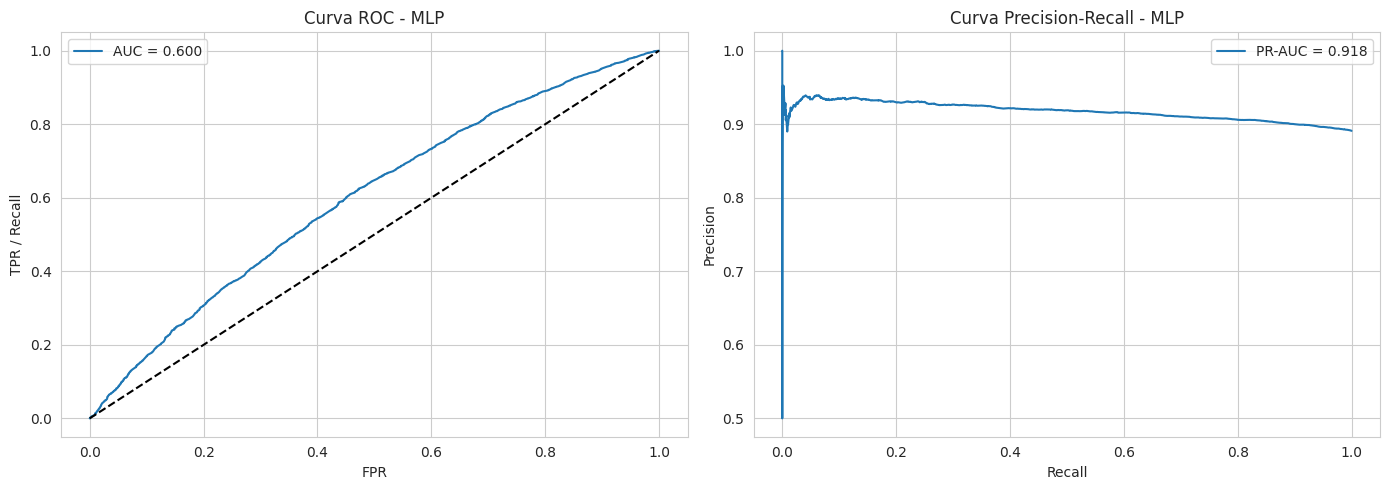

In [104]:
# ============================================
# 1. Escalamiento
# ============================================

from sklearn.preprocessing import StandardScaler

scaler_mlp = StandardScaler()
X_train_scaled = scaler_mlp.fit_transform(X_train)
X_test_scaled = scaler_mlp.transform(X_test)


# ============================================
# 2. Definir arquitectura del MLP
# ============================================

from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),   # Capas ocultas
    activation='relu',             # Función de activación
    solver='adam',                 # Optimizador
    learning_rate_init=0.001,
    max_iter=500,
    random_state=42,
    verbose=False
)

# ============================================
# 3. Entrenar la Red Neuronal
# ============================================

mlp_clf.fit(X_train_scaled, y_train)

# ============================================
# 4. Probabilidades + Predicciones
# ============================================

y_pred_proba_mlp = mlp_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_mlp = (y_pred_proba_mlp >= 0.5).astype(int)


# ============================================
# 5. Métricas del MLP
# ============================================

from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, precision_recall_curve, auc
)

print("\n=== MÉTRICAS DEL MLP ===")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_mlp):.4f}")
print(f"PR-AUC: {auc(*precision_recall_curve(y_test, y_pred_proba_mlp)[1::-1]):.4f}")
print(f"F1: {f1_score(y_test, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_mlp):.4f}")

print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_mlp))

print("\nReporte:")
print(classification_report(y_test, y_pred_mlp))


# ============================================
# 6. Graficar ROC y PR
# ============================================

fpr, tpr, _ = roc_curve(y_test, y_pred_proba_mlp)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_mlp)

plt.figure(figsize=(14,5))

# --- ROC ---
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_pred_proba_mlp):.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR / Recall")
plt.title("Curva ROC - MLP")
plt.legend()

# --- PR ---
plt.subplot(1,2,2)
plt.plot(recall, precision, label=f"PR-AUC = {auc(recall, precision):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall - MLP")
plt.legend()

plt.tight_layout()
plt.show()


#**Interpretación Final del MLP (Red Neuronal)**

Los resultados del MLP muestran un desempeño muy similar al de XGBoost, sobre todo en métricas robustas para datos desbalanceados. El modelo logra un PR-AUC = 0.918, prácticamente idéntico al mejor modelo del trabajo, lo que indica que el MLP también es capaz de capturar adecuadamente la estructura subyacente del problema. Sin embargo, su ROC-AUC (0.600) es moderado, lo que confirma que la ROC no es una métrica útil en este tipo de datos con fuerte desbalance.

El MLP obtiene un Recall ≈ 1.0, es decir, identifica casi todos los casos donde sí hubo control prenatal adecuado, aunque esto sacrifica por completo la detección de la clase minoritaria (clase 0), donde el modelo no logra recuperar prácticamente ningún caso (F1 = 0.00 para la clase negativa). En términos de política pública, el MLP prioriza minimizar falsos negativos, pero al costo de clasificar casi todo como “1”.

En conjunto, el MLP no supera a XGBoost como clasificador práctico, porque tiende a colapsar hacia la clase mayoritaria, aunque sí demuestra que la relación entre predictores y resultado es no lineal y puede capturarse mediante modelos más flexibles. Su utilidad principal es confirmar que el problema requiere modelos no lineales, pero su balance entre precisión y recall no es tan estable como el de XGBoost bajo umbral óptimo.

#Implicancias de Política Pública
Los resultados muestran que la probabilidad de acceder a controles prenatales adecuados está fuertemente asociada a factores estructurales como región, educación y nivel de riqueza, lo que confirma la existencia de brechas territoriales y socioeconómicas en salud materna. Los modelos más flexibles (como XGBoost y MLP) superan claramente al Logit en capturar patrones no lineales, lo que evidencia que la decisión de asistir a controles no responde a una relación simple, sino a mecanismos complejos donde las desventajas se acumulan. El análisis del umbral óptimo —especialmente bajo cuando no se rebalancean los datos— sugiere que, desde una perspectiva de política pública, los falsos negativos son mucho más costosos: dejar sin identificar a una madre que sí requeriría intervención implica un riesgo sanitario elevado.

Esto implica que las estrategias públicas deben priorizar modelos con alta sensibilidad (recall) y calibrados en función de costos sociales, aun si esto genera un número mayor de falsos positivos. En términos operativos, esto significa orientar recursos a detección temprana y focalización preventiva, más que a mecanismos restrictivos. Además, la importancia de variables como región, educación y riqueza refuerza la necesidad de políticas territoriales diferenciadas: mejorar acceso físico en zonas rurales, campañas educativas específicas y programas focalizados para madres jóvenes o de menor nivel socioeconómico. En conjunto, los modelos sugieren que una respuesta de política efectiva debe combinar tecnologías de predicción para identificar poblaciones de riesgo con intervenciones estructurales que reduzcan las desigualdades que originan la brecha en el uso de servicios prenatales.